<a href="https://colab.research.google.com/github/PCsujan/DataWarehouseDataMining/blob/main/Lab3all_Datawarehousing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Question 1**

In [ ]:
import pandas as pd
import math
from pprint import pprint

# Load the dataset
df = pd.read_csv('/content/laptop_buy_data.csv')

# Ensure all columns are treated as categorical
df = df.apply(lambda col: col.astype(str))

# Helper function to calculate entropy
def entropy(data):
    label_col = data.iloc[:, -1]
    labels = label_col.unique()
    entropy_value = 0
    for label in labels:
        prob = (label_col == label).mean()
        entropy_value -= prob * math.log2(prob)
    return entropy_value

# Function to calculate Information Gain
def info_gain(data, split_attribute):
    total_entropy = entropy(data)
    values = data[split_attribute].unique()
    weighted_entropy = 0
    for value in values:
        subset = data[data[split_attribute] == value]
        weighted_entropy += (len(subset) / len(data)) * entropy(subset)
    return total_entropy - weighted_entropy

# ID3 algorithm implementation
def id3(data, features):
    target = data.columns[-1]

    # Base case: all target labels are the same
    if len(data[target].unique()) == 1:
        return data[target].iloc[0]

    # Base case: no more features
    if len(features) == 0:
        return data[target].mode().iloc[0]

    # Find the best feature based on info gain
    gains = [info_gain(data, feature) for feature in features]
    best_feature = features[gains.index(max(gains))]
    tree = {best_feature: {}}

    for value in data[best_feature].unique():
        sub_data = data[data[best_feature] == value]
        if sub_data.empty:
            tree[best_feature][value] = data[target].mode().iloc[0]
        else:
            subtree = id3(sub_data.drop(columns=[best_feature]),
                          [f for f in features if f != best_feature])
            tree[best_feature][value] = subtree
    return tree

# Prepare feature list (exclude the target column)
features = list(df.columns[:-1])

# Build the tree
decision_tree = id3(df, features)

# Pretty-print the tree
print("Decision Tree (ID3):")
pprint(decision_tree)


Decision Tree (ID3):
{'Age': {'Middle_Aged': {'Income': {'High': 'No',
                                    'Low': {'Credit_Rating': {'Excellent': 'No',
                                                              'Fair': {'Student': {'Yes': 'Buy'}}}},
                                    'Medium': 'No'}},
         'Senior': {'Credit_Rating': {'Excellent': {'Income': {'High': {'Student': {'No': 'Buy'}},
                                                               'Low': 'Buy',
                                                               'Medium': 'Buy'}},
                                      'Fair': 'No'}},
         'Youth': {'Student': {'No': {'Credit_Rating': {'Excellent': 'No',
                                                        'Fair': 'Buy'}},
                               'Yes': 'Buy'}}}}


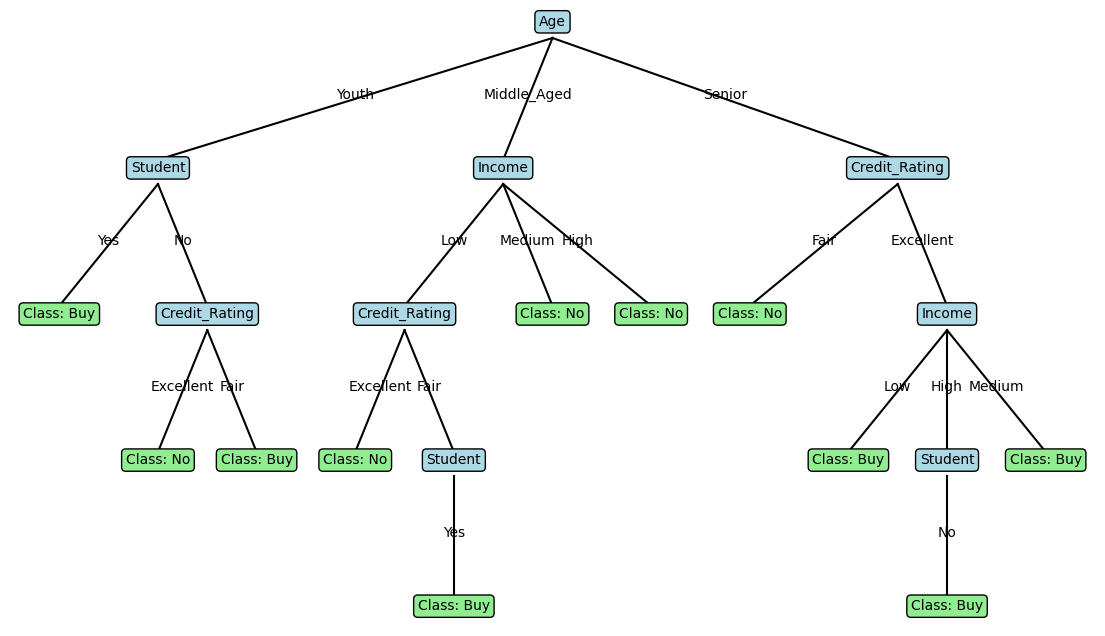

In [ ]:
import matplotlib.pyplot as plt

def get_leaf_count(tree):
    """Count leaf nodes under a given tree."""
    if not isinstance(tree, dict):
        return 1
    root = next(iter(tree))
    return sum(get_leaf_count(subtree) for subtree in tree[root].values())

def plot_tree(tree, x=0.5, y=1.0, dx=1.0, dy=0.12, ax=None, x_offset=[0]):
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.axis('off')

    if isinstance(tree, dict):
        root = next(iter(tree))
        children = tree[root]

        num_leaves = get_leaf_count(tree)
        center_x = x_offset[0] + dx * (num_leaves - 1) / 2

        ax.text(center_x, y, root, ha='center', bbox=dict(boxstyle="round", facecolor="lightblue"))

        child_x = x_offset[0]
        for val, subtree in children.items():
            leaves = get_leaf_count(subtree)
            child_center_x = child_x + dx * (leaves - 1) / 2

            ax.plot([center_x, child_center_x], [y - 0.01, y - dy + 0.01], 'k-')
            ax.text((center_x + child_center_x) / 2, y - dy / 2, str(val), ha='center')

            plot_tree(subtree, x=child_center_x, y=y - dy, dx=dx, dy=dy, ax=ax, x_offset=[child_x])

            child_x += dx * leaves
    else:
        ax.text(x, y, f"Class: {tree}", ha='center', bbox=dict(boxstyle="round", facecolor="lightgreen"))

# Call the function
plot_tree(tree)


# **Question 2**

In [ ]:
import pandas as pd

# Load the data
df = pd.read_csv('/content/laptop_buy_data.csv')

# Convert categorical values to numbers
df_encoded = df.copy()
for column in df.columns:
    df_encoded[column] = df[column].astype('category').cat.codes

# Separate features and target
X = df_encoded.iloc[:, :-1]
y = df_encoded.iloc[:, -1]

In [ ]:
# Split into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
# Naive Bayes from sklearn
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)

# Predict and check accuracy
y_pred = model.predict(X_test)

In [ ]:

results = X_test.copy()
results['Actual'] = y_test.values
results['Predicted'] = y_pred


print("Prediction Table (Sample):")
print(results.reset_index(drop=True).head(10))  # print first 10 for clarity


Prediction Table (Sample):
   Age  Income  Student  Credit_Rating  Actual  Predicted
0    1       1        0              1       1          1
1    2       2        0              0       1          0
2    1       1        1              0       0          1
3    1       0        0              1       1          1
4    2       2        0              1       0          0
5    2       1        1              0       0          0


In [ ]:
print(f"Total Correct Predictions: {(results['Actual'] == results['Predicted']).sum()} / {len(results)}")


Total Correct Predictions: 4 / 6


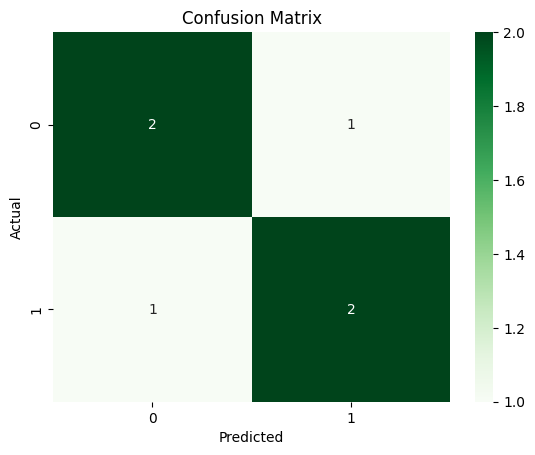

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Accuracy in percentage: ", accuracy_score(y_test, y_pred)*100 ,"%")


Accuracy: 0.6666666666666666
Accuracy in percentage:  66.66666666666666 %


# **Question 3**

In [ ]:
import numpy as np

# Input data (4 samples, 2 features each)
X = np.array([
    [-1, -1],
    [-1, 1],
    [1, -1],
    [1, 1]
])

# Target output (labels)
y = np.array([
    [-1],
    [1],
    [1],
    [-1]
])

# Sigmoid activation function and its derivative
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)  # derivative of sigmoid

# Normalize target to 0 or 1 (sigmoid works in 0-1)
y = (y + 1) / 2  # now -1 => 0, +1 => 1

# Initialize weights randomly
np.random.seed(1)
input_layer_neurons = 2
hidden_layer_neurons = 2
output_neurons = 1

# Weights
wh = 2 * np.random.random((input_layer_neurons, hidden_layer_neurons)) - 1
bh = np.zeros((1, hidden_layer_neurons))

wo = 2 * np.random.random((hidden_layer_neurons, output_neurons)) - 1
bo = np.zeros((1, output_neurons))

# Learning rate
lr = 0.1

# Training loop
for epoch in range(10000):
    # Forward pass
    zh = np.dot(X, wh) + bh
    ah = sigmoid(zh)

    zo = np.dot(ah, wo) + bo
    ao = sigmoid(zo)

    # Compute error
    error = y - ao
    if epoch % 1000 == 0:
        print(f"Epoch {epoch} Error: {np.mean(np.abs(error))}")

    # Backpropagation
    d_output = error * sigmoid_derivative(ao)
    error_hidden = d_output.dot(wo.T)
    d_hidden = error_hidden * sigmoid_derivative(ah)

    # Update weights
    wo += ah.T.dot(d_output) * lr
    bo += np.sum(d_output, axis=0, keepdims=True) * lr
    wh += X.T.dot(d_hidden) * lr
    bh += np.sum(d_hidden, axis=0, keepdims=True) * lr

# Convert output back to -1 or 1
final_output = np.where(ao > 0.5, 1, -1)
final_output1 = np.where(ao > 0.5, 1, 0)
print("Predicted Output after training:\n")
print("Final output as -1 and 1");
print(final_output)

print("Final output as 0 and 1");
print(final_output1)


Epoch 0 Error: 0.49885183066270666
Epoch 1000 Error: 0.49800103082525693
Epoch 2000 Error: 0.428095321757062
Epoch 3000 Error: 0.24981704910738842
Epoch 4000 Error: 0.11547292863902894
Epoch 5000 Error: 0.08312127651220597
Epoch 6000 Error: 0.06769305359929269
Epoch 7000 Error: 0.058335198249613716
Epoch 8000 Error: 0.05192321682458555
Epoch 9000 Error: 0.047192045810484536
Predicted Output after training:

Final output as -1 and 1
[[-1]
 [ 1]
 [ 1]
 [-1]]
Final output as 0 and 1
[[0]
 [1]
 [1]
 [0]]
